In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib
from tqdm import tqdm

%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
rawtext = open("/media/joe/HD/data/gutenberg/alice_in_wonderland.txt", "r").read()[710:]
len(rawtext)

172656

In [3]:
split = int(0.9*len(rawtext))
trainraw = rawtext.lower()[:split]
testraw = rawtext.lower()[split:]

In [4]:
chars = sorted(list(set(rawtext.lower())))
charmap = {chars[i]:i for i in range(len(chars))}
len(chars)

60

In [5]:
#rnn_model_dir = '/media/joe/HD/text_pred_models/alice_rnn_256_adam_export/1536113383/'
#lstm_model_dir = '/media/joe/HD/text_pred_models/alice_lstm_256_adam_export/1536116411/'
model_dir = "/media/joe/HD/text_pred_models/alice_in_wonderland_lstm_256_export/1537322950/"

In [6]:
# probs, state

In [7]:
class TextGenerator():
    def __init__(self, logdir, seq_len=25):
        self._predict = tf.contrib.predictor.from_saved_model(logdir)
        self._seq_len = seq_len
        
    def __call__(self, text, n=50):
        text = " "*self._seq_len + text
        state = []
        for _ in tqdm(range(n)):
            inputs = np.expand_dims(np.array([charmap[c] for c in text[-25:]], 
                                             dtype=np.int32), 0)
            prediction = self._predict({"x":inputs})
            probs = prediction["probs"].ravel()
            state.append(prediction["state"].ravel())
            next_char_index = np.random.choice(np.arange(len(probs)), p=probs)
            text += chars[next_char_index]
        return text.strip(), np.stack(state)

In [8]:
#rnn = TextGenerator(rnn_model_dir)
#lstm = TextGenerator(lstm_model_dir)
model = TextGenerator(model_dir)

INFO:tensorflow:Restoring parameters from /media/joe/HD/text_pred_models/alice_in_wonderland_lstm_256_export/1537322950/variables/variables


In [11]:
t, s = model("this is a test", 150)
print(t)
print(len(t))
print(s.shape)

100%|██████████| 150/150 [00:01<00:00, 76.58it/s]

this is a test mouch it my ear
that is stoped begre, under the wish was as it deeply "you may seal is a little very curious!'

"all then," the hatter asked.

"did y
164
(150, 256)


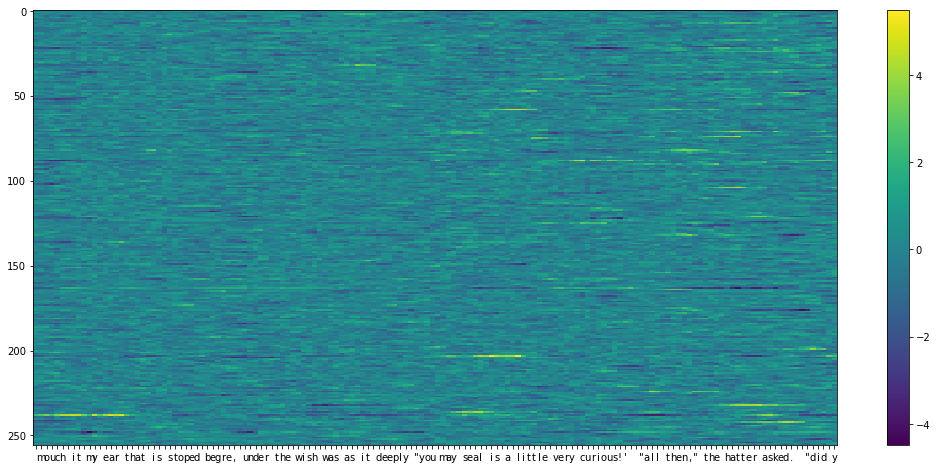

In [12]:
figsize(18,8)
states = s.T
state_means = states.mean(axis=1)
states_shifted = np.stack([states[:,i]-state_means for 
                           i in range(states.shape[1])]).T
plt.imshow(states_shifted, interpolation="none", aspect="auto")
numchars = s.shape[0]
plt.xticks(np.arange(numchars), list(t[-numchars:]), fontsize=10)
plt.colorbar();